In [ ]:
!pip install openmeteo-requests
!pip install requests-cache retry-requests numpy pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.0 MB/s eta 0:00:00


In [ ]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": -29,
	"longitude": 24,
	"start_date": "2010-01-01",
	"end_date": "2019-12-31",
	"hourly": "temperature_2m",
	"daily": ["sunrise", "sunset", "daylight_duration", "sunshine_duration"],
	"timezone": "GMT"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°E {response.Longitude()}°N")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s"),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s"),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m

hourly_dataframe = pd.DataFrame(data = hourly_data)
print(hourly_dataframe)

# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_sunrise = daily.Variables(0).ValuesAsNumpy()
daily_sunset = daily.Variables(1).ValuesAsNumpy()
daily_daylight_duration = daily.Variables(2).ValuesAsNumpy()
daily_sunshine_duration = daily.Variables(3).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s"),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s"),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}
daily_data["sunrise"] = daily_sunrise
daily_data["sunset"] = daily_sunset
daily_data["daylight_duration"] = daily_daylight_duration
daily_data["sunshine_duration"] = daily_sunshine_duration

daily_dataframe = pd.DataFrame(data = daily_data)
print(daily_dataframe)

Coordinates -28.99824333190918°E 24.04816436767578°N
Elevation 1129.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
                     date  temperature_2m
0     2010-01-01 00:00:00       22.577999
1     2010-01-01 01:00:00       22.528000
2     2010-01-01 02:00:00       22.727999
3     2010-01-01 03:00:00       22.727999
4     2010-01-01 04:00:00       22.778000
...                   ...             ...
87643 2019-12-31 19:00:00       26.534500
87644 2019-12-31 20:00:00       25.884501
87645 2019-12-31 21:00:00       25.434500
87646 2019-12-31 22:00:00       23.734499
87647 2019-12-31 23:00:00       21.734499

[87648 rows x 2 columns]
           date  sunrise  sunset  daylight_duration  sunshine_duration
0    2010-01-01        0       0       50235.773438       25924.832031
1    2010-01-02        0       0       50207.675781        4358.736816
2    2010-01-03        0       0       50177.281250       39612.343750
3    2010-01-04        0       0       50144.625000       

In [ ]:
daily_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3652 entries, 0 to 3651
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               3652 non-null   datetime64[ns]
 1   sunrise            3652 non-null   int64         
 2   sunset             3652 non-null   int64         
 3   daylight_duration  3652 non-null   float32       
 4   sunshine_duration  3652 non-null   float32       
dtypes: datetime64[ns](1), float32(2), int64(2)
memory usage: 114.2 KB


       sunrise  sunset  daylight_duration  sunshine_duration
count   3652.0  3652.0        3652.000000        3652.000000
mean       0.0     0.0       43577.535156       38657.734375
std        0.0     0.0        4603.131836        6421.094727
min        0.0     0.0       37039.929688         332.471924
25%        0.0     0.0       39089.395508       34605.792969
50%        0.0     0.0       43463.007812       39054.136719
75%        0.0     0.0       48048.495117       43608.377930
max        0.0     0.0       50387.671875       46974.527344


<ipython-input-6-024b0d1cc282>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = daily_dataframe.corr()


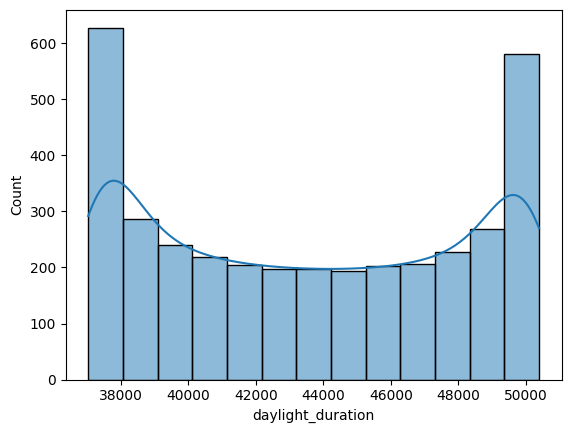

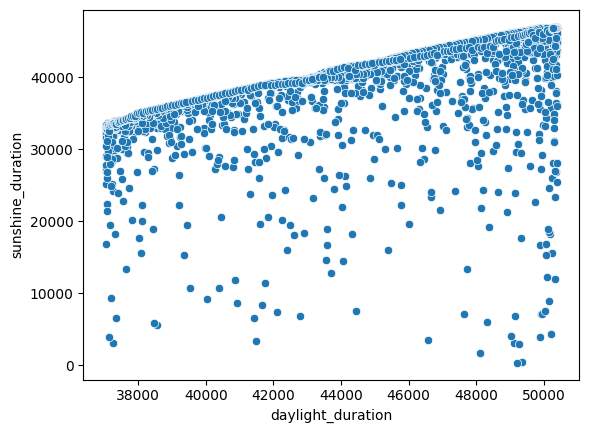

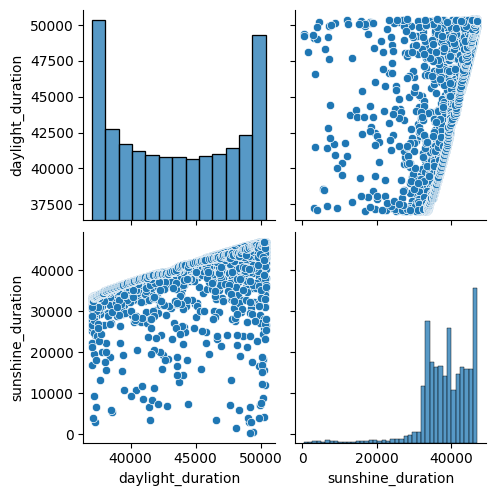

In [ ]:

print(daily_dataframe.describe())

# Correlation matrix
correlation_matrix = daily_dataframe.corr()

# Univariate analysis
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(daily_dataframe['daylight_duration'], kde=True)
plt.show()

# Bivariate analysis
sns.scatterplot(x='daylight_duration', y='sunshine_duration', data=daily_dataframe)
plt.show()

# Pairplot for multiple features
sns.pairplot(daily_dataframe[['daylight_duration', 'sunshine_duration', 'date']])
plt.show()

In [ ]:
# Bar chart
sns.countplot(x='date', data=daily_dataframe)
plt.show()

# Box plot
sns.boxplot(x='date', y='numeric_column', data=daily_dataframe)
plt.show()

# Heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

# Line plot
sns.lineplot(x='date', y='numeric_column', data=daily_dataframe)
plt.show()

# Customizing plots
plt.figure(figsize=(10, 6))
sns.histplot(daily_dataframe['numeric_column'], kde=True, bins=30, color='skyblue')
plt.title('Distribution of Numeric Column')
plt.xlabel('Numeric Column')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Add a 'date' column as the index for both hourly and daily dataframes
hourly_dataframe.set_index('date', inplace=True)
daily_dataframe.set_index('date', inplace=True)

# Merge daily data with corresponding hourly data
merged_dataframe = pd.merge(hourly_dataframe, daily_dataframe, left_index=True, right_index=True, how='outer')

# Handle missing values if needed
merged_dataframe.dropna(inplace=True)

# Extract additional time-related features
merged_dataframe['month'] = merged_dataframe.index.month
merged_dataframe['day_of_week'] = merged_dataframe.index.dayofweek
merged_dataframe['hour'] = merged_dataframe.index.hour


       temperature_2m  sunrise  sunset  daylight_duration  sunshine_duration  \
count     3652.000000   3652.0  3652.0        3652.000000        3652.000000   
mean        14.128429      0.0     0.0       43577.535156       38657.734375   
std          6.269567      0.0     0.0        4603.131836        6421.094727   
min         -1.822000      0.0     0.0       37039.929688         332.471924   
25%          9.128000      0.0     0.0       39089.395508       34605.792969   
50%         14.731250      0.0     0.0       43463.007812       39054.136719   
75%         19.284500      0.0     0.0       48048.495117       43608.377930   
max         30.128000      0.0     0.0       50387.671875       46974.527344   

             month  day_of_week    hour  
count  3652.000000  3652.000000  3652.0  
mean      6.523549     3.000274     0.0  
std       3.449005     2.000753     0.0  
min       1.000000     0.000000     0.0  
25%       4.000000     1.000000     0.0  
50%       7.000000     3.00

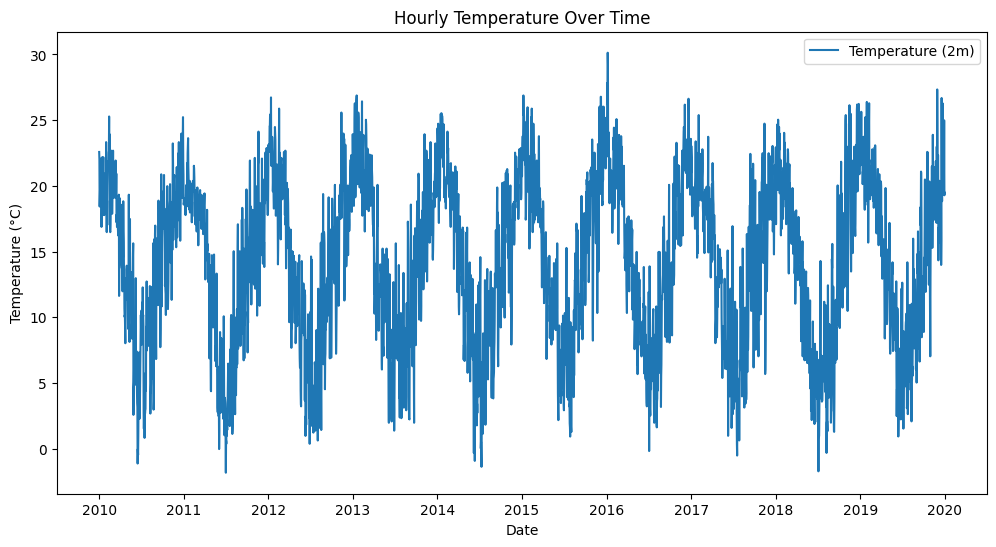

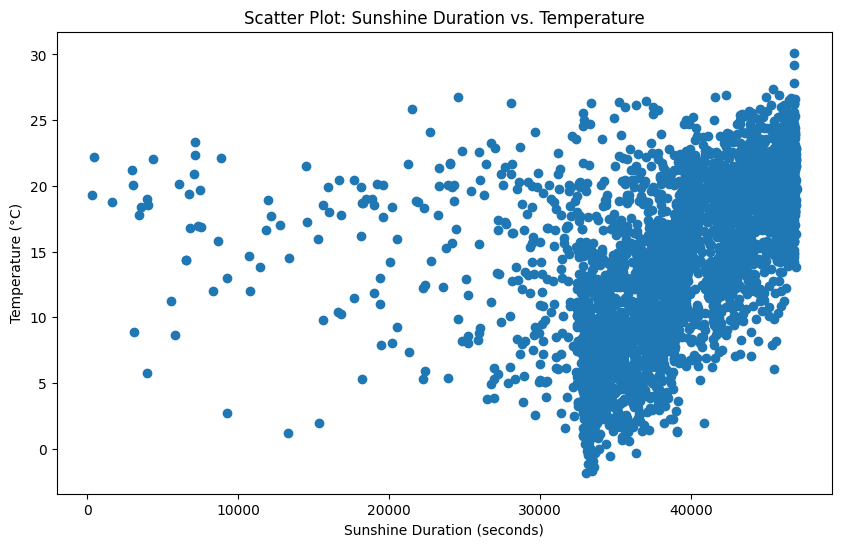

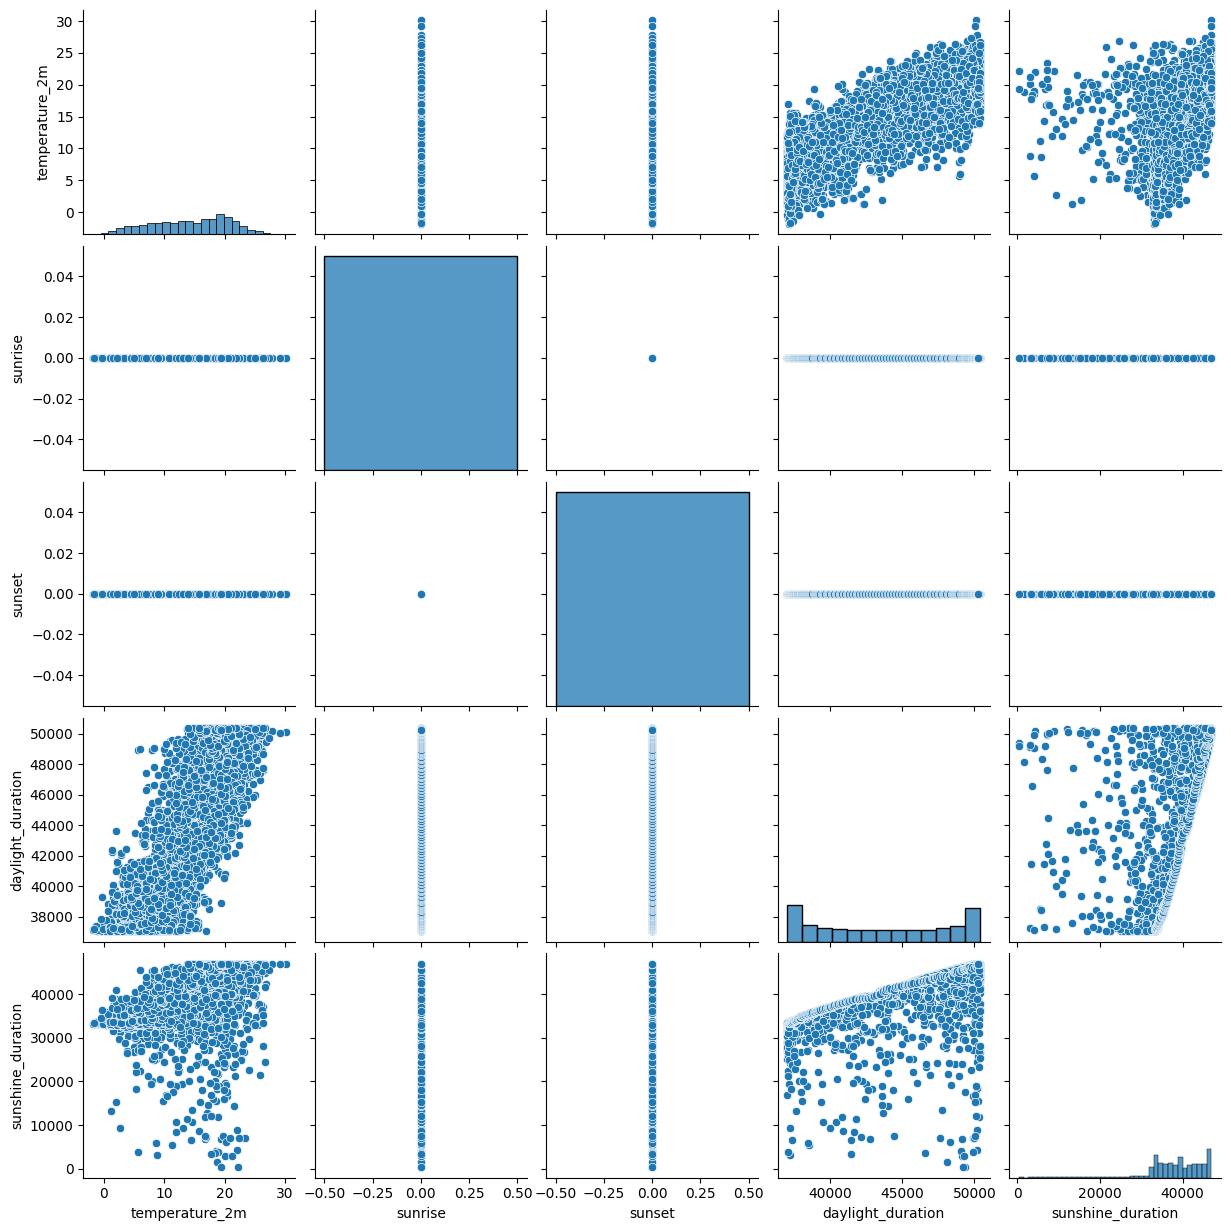

In [ ]:
# Basic statistics
print(merged_dataframe.describe())

# Line plot of temperature over time
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(merged_dataframe.index, merged_dataframe['temperature_2m'], label='Temperature (2m)')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Hourly Temperature Over Time')
plt.legend()
plt.show()

# Scatter plot of sunshine duration vs. temperature
plt.figure(figsize=(10, 6))
plt.scatter(merged_dataframe['sunshine_duration'], merged_dataframe['temperature_2m'])
plt.xlabel('Sunshine Duration (seconds)')
plt.ylabel('Temperature (°C)')
plt.title('Scatter Plot: Sunshine Duration vs. Temperature')
plt.show()

# Pairplot for selected features
import seaborn as sns
selected_features = ['temperature_2m', 'sunrise', 'sunset', 'daylight_duration', 'sunshine_duration']
sns.pairplot(merged_dataframe[selected_features])
plt.show()


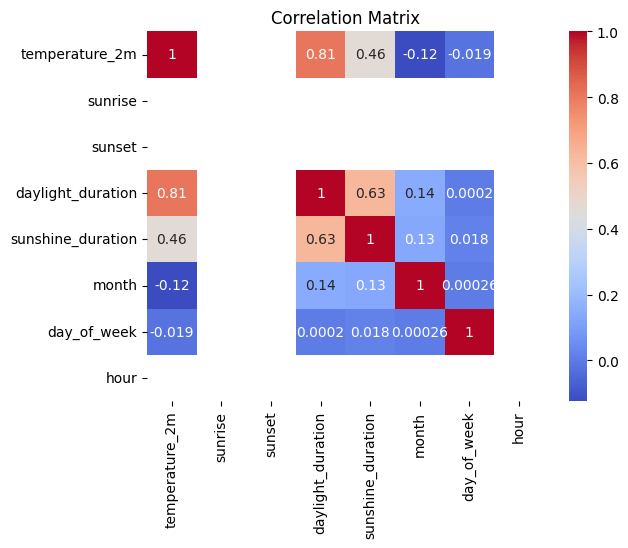

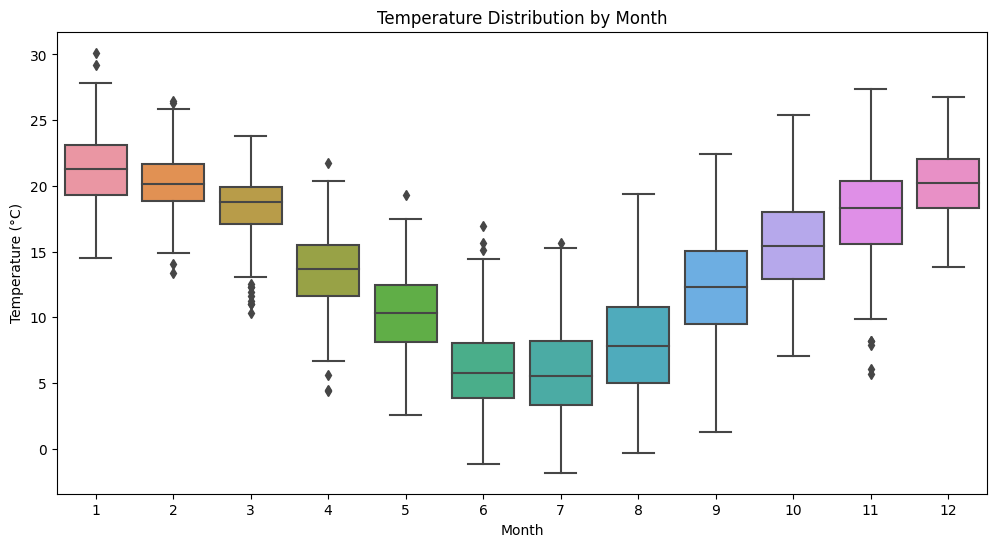

In [ ]:
# Heatmap of correlations
correlation_matrix = merged_dataframe.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Boxplot of temperature by month
plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='temperature_2m', data=merged_dataframe)
plt.xlabel('Month')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Distribution by Month')
plt.show()

# Interpretations
# 1. Explore the patterns in temperature over time.
# 2. Investigate the relationship between sunshine duration and temperature.
# 3. Analyze the monthly variation in temperature.
# 4. Check if there are any outliers or anomalies in the data.
